In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)

#import data_prediction.csv. it's subset of the original file and will be be sufficient for testing.

In [3]:
data.head()

AREA NAME  Vict Age Vict Sex     Vict Descent Status  \
0    Southwest        36        F            Black     AO   
1      Central        25        M  Hispanic/Latino     IC   
2      Central        30  Unknown            Other     AA   
3  N Hollywood        76        F            White     IC   
4      Mission        31  Unknown            Other     IC   

                                   LOCATION      LAT       LON  \
0   1100 W  39TH                         PL  34.0141 -118.2978   
1    700 S  HILL                         ST  34.0459 -118.2545   
2    200 E  6TH                          ST  34.0448 -118.2474   
3   5400    CORTEEN                      PL  34.1685 -118.4019   
4  14400    TITUS                        ST  34.2198 -118.4468   

                         Crime Category Weapon Category DATE OCC Month  Year  \
0                        Violent Crimes  Physical Force     2020-01-01  2020   
1                        Violent Crimes         Unknown     2020-01-01  2020   
2                            Sex Crimes         Unknown     2020-02-01  2020   
3  Crimes Against Property and Vehicles         Unknown     2020-01-01  2020   
4                       Property Crimes         Unknown     2020-01-01  2020   

  Time Period  Population  Crime Cnt  Crime Rate Age Group  
0  9PM - 12AM       55859      11149    0.199592     31-45  
1   3AM - 6AM       53150      11586    0.217987     19-30  
2  9AM - 12PM       53150      11586    0.217987     19-30  
3   3PM - 6PM       39429      10151    0.257450     76-90  
4   3AM - 6AM       18895       8458    0.447632     31-45

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392184 entries, 0 to 392183
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AREA NAME        392184 non-null  object 
 1   Vict Age         392184 non-null  int64  
 2   Vict Sex         392184 non-null  object 
 3   Vict Descent     392184 non-null  object 
 4   Status           392184 non-null  object 
 5   LOCATION         392184 non-null  object 
 6   LAT              392184 non-null  float64
 7   LON              392184 non-null  float64
 8   Crime Category   392184 non-null  object 
 9   Weapon Category  392184 non-null  object 
 10  DATE OCC Month   392184 non-null  object 
 11  Year             392184 non-null  int64  
 12  Time Period      392184 non-null  object 
 13  Population       392184 non-null  int64  
 14  Crime Cnt        392184 non-null  int64  
 15  Crime Rate       392184 non-null  float64
 16  Age Group        392184 non-null  obje

In [5]:
data['Year'] = data.Year.astype('str')

In [6]:
data['Vict Descent'].unique()

array(['Black', 'Hispanic/Latino', 'Other', 'White', 'Asian',
       'Native American'], dtype=object)

In [7]:
#Spliting the data to data_num and data_cat

data_num = data[[x for x in data.columns if data[x].dtype != 'O']]
data_cat = data[[x for x in data.columns if data[x].dtype == 'O']]

In [8]:
#Vict Descent to number

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

vict_descent = label_encoder.fit_transform(data_cat['Vict Descent'])

In [9]:
data_cat['Vict Descent'] = vict_descent

data_cat['Vict Descent'].unique()

array([1, 2, 4, 5, 0, 3])

In [10]:
#feature engineer(mean) on data_cat

for x in data_cat.columns:
    if x != 'Vict Descent':
        dict1 = data_cat.groupby([x])['Vict Descent'].mean().to_dict()
        data_cat[x] = data_cat[x].map(dict1)
        
df = pd.concat([data_cat, data_num], axis=1)

df.drop(['Population', 'Crime Cnt', 'Crime Rate'], axis=1, inplace=True)

In [11]:
#Correlation
df.corr()['Vict Descent'].sort_values(ascending=False)

Vict Descent       1.000000
LOCATION           0.542014
Vict Sex           0.346099
AREA NAME          0.320354
Crime Category     0.294678
Weapon Category    0.258469
Age Group          0.202882
Status             0.123909
DATE OCC Month     0.024530
Time Period        0.023798
LAT                0.009612
Year               0.004843
LON               -0.006755
Vict Age          -0.008696
Name: Vict Descent, dtype: float64

In [12]:
plt.figure(figsize=(14, 7))
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:>

In [13]:
#Select the best column use for analysis 
#Option1 

X = df.drop('Vict Descent', axis=1)
y = df.loc[:, 'Vict Descent']

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(Lasso(0.005))
model.fit(X, y)
model.get_support()

array([ True,  True, False,  True,  True,  True, False, False, False,
        True,  True, False,  True])

In [14]:
selected_feature = X.columns[model.get_support()]
X[selected_feature]

AREA NAME  Vict Sex  LOCATION  Crime Category  Weapon Category  \
0        2.413407  2.558148  2.750000        2.407950         2.457906   
1        2.772714  2.917305  3.250000        2.407950         3.285141   
2        2.772714  3.996277  3.161111        2.765855         3.285141   
3        3.541667  2.558148  3.631579        3.701748         3.285141   
4        2.763471  3.996277  4.000000        3.203664         3.285141   
...           ...       ...       ...             ...              ...   
392179   3.622859  2.917305  3.194444        2.254849         2.332568   
392180   3.021797  2.558148  2.428571        3.203664         3.285141   
392181   2.841321  3.996277  3.000000        3.701748         3.285141   
392182   2.413407  2.558148  1.945607        3.203664         3.285141   
392183   2.669997  3.996277  2.727273        3.701748         3.285141   

        Age Group  Vict Age       LON  
0        2.702802        36 -118.2978  
1        3.311924        25 -118.2545  
2        3.311924        30 -118.2474  
3        3.354293        76 -118.4019  
4        2.702802        31 -118.4468  
...           ...       ...       ...  
392179   2.702802        36 -118.4729  
392180   3.311924        19 -118.2902  
392181   3.311924        30 -118.2741  
392182   2.182064        15 -118.3351  
392183   3.311924        30 -118.3022  

[392184 rows x 8 columns]

In [15]:
#Option2 

from sklearn.feature_selection import mutual_info_regression

imp = mutual_info_regression(X, y)

In [16]:
pd.DataFrame(imp, index=X.columns).sort_values(0, ascending=False)

0
Vict Sex         0.334812
Vict Age         0.264861
LOCATION         0.255276
Crime Category   0.132684
Age Group        0.122758
AREA NAME        0.114971
LAT              0.110681
LON              0.103341
Weapon Category  0.067135
Status           0.017231
Time Period      0.002235
DATE OCC Month   0.002045
Year             0.000467

In [17]:
#Option3

from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import chi2

orderd_rank_features = SelectKBest(score_func=chi2, k='all')

ordered_feature = orderd_rank_features.fit(X.drop(['LON'], axis=1), y)

In [18]:
ordered_feature.scores_

array([4.38285291e+03, 2.18221884e+04, 1.54269650e+02, 2.83492167e+04,
       5.56966644e+03, 2.54185672e+03, 1.96890252e-01, 2.38675912e-03,
       2.01752672e-01, 2.21351631e+03, 1.41594972e+05, 1.58938163e+01])

In [19]:
ordered_df = pd.concat(
    [
     pd.DataFrame(X.drop('LON', axis=1).columns),
     pd.DataFrame(ordered_feature.scores_, columns=['score'])
    ], axis=1
).sort_values('score', ascending=False)

selected_features = ordered_df[:8][0].values

selected_features

array(['Vict Age', 'LOCATION', 'Vict Sex', 'Crime Category', 'AREA NAME',
       'Weapon Category', 'Age Group', 'Status'], dtype=object)

In [20]:
X = X[selected_features]

In [21]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [22]:
#Display score

def display_scores(scores):
    print('===============================================')
    print('Scores: {}'.format(scores))
    print('===============================================')
    print('Mean Score: {}'.format(scores.mean()))
    print('===============================================')
    print('Standard Deviation of Scores: {}'.format(scores.std()))
    print('===============================================')
    
    return None

In [23]:
#Creat the predict function 

def predict(ml_model):
    model = ml_model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f'Predictions: {pred}')
    print(f'Training Score: {model.score(X_train, y_train)}')
    print('\n')
    print(f'{confusion_matrix(pred, y_test)}')
    print('\n')
    print(f'Accuracy Score: {accuracy_score(pred, y_test)}')
    print(f'Mean Squared Error: {mean_squared_error(pred, y_test)}')
    
    scores = cross_val_score(model,
               X_train,
               y_train,
#                scoring='neg_mean_squared_error',
               cv=10)
    print('\n')
    display_scores(scores)
    
    plt.figure(figsize=(4,2))
    sns.kdeplot(pred, shade=True)
    sns.kdeplot(y_test, shade=True)
    plt.legend(['pred', 'y_test'])
    
    print('\n')
    plt.show()

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Predictions: [4 1 2 ... 2 4 2]
Training Score: 0.9653794484002695


[[ 1027   763  1668    14   578  1131]
 [  723  7957  7145    13  1200  2547]
 [ 1487  6834 22803    26  2830  5288]
 [    5    24    35     3    13    32]
 [  521  1151  2925    10 30349  3934]
 [  937  2393  5355    35  3431 14234]]


Accuracy Score: 0.5901128873984902
Mean Squared Error: 2.506633390253514


Scores: [0.596339   0.58990752 0.58511246 0.587304   0.58581976 0.58711372
 0.58951134 0.58901659 0.5867712  0.58460192]
Mean Score: 0.5881497512597689
Standard Deviation of Scores: 0.0032200803410404625




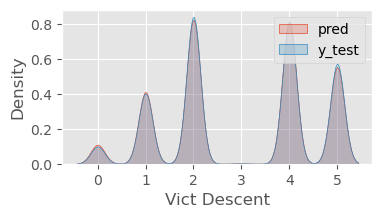

In [25]:
#Predictions - Tree

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

predict(tree)

Predictions: [5 2 2 ... 2 4 2]
Training Score: 0.9653566141351713


[[  784   434   784     7   309   615]
 [  618  7638  5314    13   789  1613]
 [ 1886  8165 27362    26  3223  6005]
 [    3     5    15     2     7    13]
 [  375   647  1579    13 29820  2553]
 [ 1034  2233  4877    40  4253 16367]]


Accuracy Score: 0.6333825267924061
Mean Squared Error: 2.134329050154148


Scores: [0.63766792 0.63192145 0.63055143 0.63540874 0.62981428 0.63312529
 0.63792054 0.63430507 0.63107018 0.63578931]
Mean Score: 0.633757420685007
Standard Deviation of Scores: 0.002767621351482109




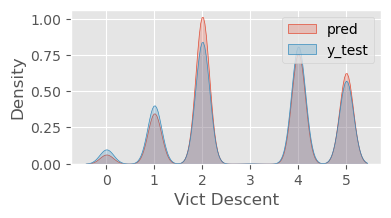

In [26]:
#Predictions - forest

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

predict(forest)

In [27]:
#Predictions - KNN

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

predict(knn)

Predictions: [5 2 1 ... 2 4 1]
Training Score: 0.7206189608125954


[[  725   477  1103     6   304   628]
 [  719  7280  7164    17   973  1973]
 [ 2145  9240 26256    32  3703  7077]
 [    0     1     0     1     0     0]
 [  293   546  1471     7 29595  2842]
 [  818  1578  3937    38  3826 14646]]


Accuracy Score: 0.606570803810819
Mean Squared Error: 2.1139382325897653


Scores: [0.60767972 0.60433078 0.60178103 0.60275537 0.6037068  0.60652306
 0.60823565 0.60149947 0.60484853 0.6074745 ]
Mean Score: 0.6048834914312349
Standard Deviation of Scores: 0.002361239874491423




In [28]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

predict(xgb)

Predictions: [5 2 2 ... 2 4 1]
Training Score: 0.6828815320269597


[[  522    88   127     0    50    77]
 [  364  7113  3489     9   397   660]
 [ 2376  9210 31014    40  3606  6538]
 [    0     0     1     0     0     0]
 [   69   160   456     5 29271  1059]
 [ 1369  2551  4844    47  5077 18832]]


Accuracy Score: 0.6703085279823212
Mean Squared Error: 1.8752598110043965


Scores: [0.674354   0.66929254 0.66875975 0.6728193  0.66676815 0.67087837
 0.67502664 0.6700411  0.66947024 0.67335211]
Mean Score: 0.6710762201009024
Standard Deviation of Scores: 0.00255664680473998




In [29]:
#Parameter Tunning on XGBClassifier

In [30]:
from sklearn.model_selection import RandomizedSearchCV

params={
    'learning_rate':[0.05, 0.20, 0.25],
    'max_depth':[5, 8, 10],
    'min_child_weight':[1, 3, 5, 7],
    'gamma':[0.0, 0.1, 0.2, 0.4],
    'colsample_bytree':[0.3, 0.4, 0.7]
}

random_search = RandomizedSearchCV(xgb, 
                  param_distributions=params, 
                  n_iter=5,
                  scoring='roc_auc',
                  n_jobs=-1, 
                  cv=5,
                  verbose=3)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition fo

/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition fo

/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/aaronzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition fo

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                

In [31]:
random_search.best_params_

{'min_child_weight': 7,
 'max_depth': 10,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [32]:
features = pd.DataFrame(random_search.best_estimator_.feature_importances_, index=X.columns).reset_index()

sns.barplot(data=features, y='index', x=0)

<AxesSubplot:xlabel='0', ylabel='index'>

Predictions: [5 2 2 ... 2 4 1]
Training Score: 0.6714605937670067


[[  299    25    13     0     7     7]
 [  283  5858  2499     4   224   326]
 [ 2638 10475 31970    45  3760  7079]
 [    0     0     0     0     0     0]
 [  172   381   951     5 29534  1854]
 [ 1308  2383  4498    47  4876 17900]]


Accuracy Score: 0.6611060028897938
Mean Squared Error: 1.8423207980157779
[CV 3/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=3;, score=nan total time= 1.0min
[CV 5/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=3;, score=nan total time= 1.0min
[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=8, min_child_weight=3;, score=nan total time= 1.0min
[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=10, min_child_weight=7;, score=nan total time= 1.2min
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=8, min_child_weight=3;, score=na

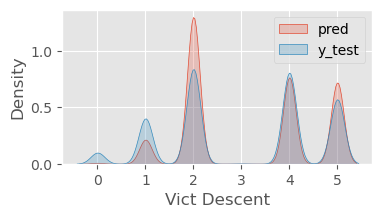

In [33]:
predict(random_search.best_estimator_)

In [34]:
#Parameter Tunning on Decision Tree 

from sklearn.model_selection import GridSearchCV

params = {'criterion': ['gini', 'entropy'],
          'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'max_features': [None, 'sqrt', 'log2']}

grid_search  = GridSearchCV(tree,
                            params, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [35]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [36]:
tree_features = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index=X.columns).reset_index()

sns.barplot(data = tree_features, x=0, y='index')

<AxesSubplot:xlabel='0', ylabel='index'>

Predictions: [5 2 2 ... 2 4 1]
Training Score: 0.6567058528027158


[[  360    63    84     0    30    26]
 [  264  5960  2960     4   239   346]
 [ 2807 10800 32014    49  4525  8010]
 [    0     0     0     0     0     0]
 [   28    60   183     2 27732   590]
 [ 1241  2239  4690    46  5875 18194]]


Accuracy Score: 0.6510535384520286
Mean Squared Error: 1.8710487478848101


Scores: [0.65536401 0.65056894 0.64748639 0.65344801 0.65040341 0.65576952
 0.65497032 0.64789161 0.65009895 0.65447557]
Mean Score: 0.652047673088217
Standard Deviation of Scores: 0.0029667082418294234




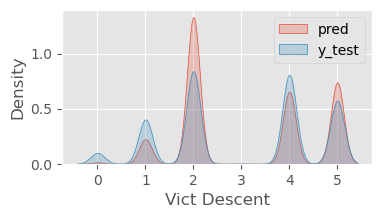

In [37]:
predict(grid_search.best_estimator_)